In [1]:
# Install Kaggle API
!pip install kaggle

# Set up Kaggle API Key (Replace YOUR_USERNAME and YOUR_KEY with actual values)
!mkdir -p ~/.kaggle
!echo '{"username":"nirfana","key":"x"}' > ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

# Download the dataset (Replace username/dataset-name with the actual dataset path)
!kaggle datasets download -d nadyinky/sephora-products-and-skincare-reviews

# Unzip the dataset if necessary
!unzip sephora-products-and-skincare-reviews.zip

Dataset URL: https://www.kaggle.com/datasets/nadyinky/sephora-products-and-skincare-reviews
License(s): Attribution 4.0 International (CC BY 4.0)
100% 147M/147M [00:09<00:00, 21.5MB/s]
100% 147M/147M [00:09<00:00, 15.6MB/s]
Archive:  sephora-products-and-skincare-reviews.zip
  inflating: product_info.csv        
  inflating: reviews_0-250.csv       
  inflating: reviews_1250-end.csv    
  inflating: reviews_250-500.csv     
  inflating: reviews_500-750.csv     
  inflating: reviews_750-1250.csv    


# Graded Challenge 7 - Natural Language Processing
---

# 1. Introduction


**Name**    : Devi Nirfana Hermawan<br>
**Bacth**   : HCK-16

**Objection**:<br>
The primary objective of this project is to develop a sophisticated Natural Language Processing (NLP) model capable of analyzing user reviews of Sephora skincare products. The model aims to determining whether a product is recommended by the reviewer.

The dataset, collected via [Python scraper](https://github.com/nadyinky/sephora-analysis/tree/main/sephora_scraper) in March 2023, includes information about over 8,000 beauty products from the Sephora online store, such as product and brand names, prices, ingredients, ratings, and features. Additionally, it contains approximately one million user reviews for over 2,000 skincare products, including user appearances and review ratings by other users. This extensive dataset will enable the model to provide valuable insights into customer satisfaction, guide product enhancements, and assist consumers in making informed purchasing decisions. The project will involve data preparation, text preprocessing, model training, evaluation, deployment, and continuous improvement to ensure the model's accuracy and relevance.

# 2. Import Libraries

In [2]:
# for data manipulation
import pandas as pd
import numpy as np

# for data visualization
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from wordcloud import STOPWORDS

# for text preprocess
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from imblearn.under_sampling import NearMiss

# for model buidling
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

from tensorflow.keras.utils import plot_model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TextVectorization, Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# for model evaluation
from sklearn.metrics import classification_report

# initialize necessary packages
nltk.download('stopwords')
nltk.download('punkt')

# hide all warnings
import warnings
warnings.filterwarnings('ignore')

# show all columns
pd.options.display.max_columns = None

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


# 3. Data Loading  

**Reviews data content**

| **Feature** |	**Description** |
| --- | --- |
| `author_id` | The unique identifier for the author of the review on the website |
| `rating` | The rating given by the author for the product on a scale of 1 to 5 |
| `is_recommended` | Indicates if the author recommends the product or not (1-true, 0-false) |
| `helpfulness` | The ratio of all ratings to positive ratings for the review: helpfulness = total_pos_feedback_count /  |total_feedback_count
| `total_feedback_count` | Total number of feedback (positive and negative ratings) left by users for the review |
| `total_neg_feedback_count` | The number of users who gave a negative rating for the review |
| `total_pos_feedback_count` | The number of users who gave a positive rating for the review |
| `submission_time` | Date the review was posted on the website in the 'yyyy-mm-dd' format |
| `review_text` | The main text of the review written by the author |
| `review_title` | The title of the review written by the author |
| `skin_tone` | Author's skin tone (e.g. fair, tan, etc.) |
| `eye_color` | Author's eye color (e.g. brown, green, etc.) |
| `skin_type` | Author's skin type (e.g. combination, oily, etc.) |
| `hair_color` | Author's hair color (e.g. brown, auburn, etc.) |
| `product_id` | The unique identifier for the product on the website |

In [5]:
# load each revie data
df_raw = pd.read_csv('reviews_0-250.csv')

# Remove the unnamed columns that comes from index from each review dataframe
df_raw = df_raw.loc[:, ~df_raw.columns.str.contains('^Unnamed')]

df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 602130 entries, 0 to 602129
Data columns (total 18 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   author_id                 602130 non-null  object 
 1   rating                    602130 non-null  int64  
 2   is_recommended            484644 non-null  float64
 3   helpfulness               270298 non-null  float64
 4   total_feedback_count      602130 non-null  int64  
 5   total_neg_feedback_count  602130 non-null  int64  
 6   total_pos_feedback_count  602130 non-null  int64  
 7   submission_time           602130 non-null  object 
 8   review_text               601131 non-null  object 
 9   review_title              435119 non-null  object 
 10  skin_tone                 496074 non-null  object 
 11  eye_color                 463642 non-null  object 
 12  skin_type                 527447 non-null  object 
 13  hair_color                461049 non-null  o

The dataset comprises 1,094,411 entries with 18 columns, capturing a wide range of information about Sephora skincare product reviews. The data types are diverse, including 3 columns of float64, 4 columns of int64, and 11 columns of object type.

But it seems like the `is_recommended` column are not in the right data type, as a binary indicator it should have integer data type. The data type will be altered later during feature engineering.

In [6]:
# show first 5 rows
df_raw.head()

,author_id,rating,is_recommended,helpfulness,total_feedback_count,total_neg_feedback_count,total_pos_feedback_count,submission_time,review_text,review_title,skin_tone,eye_color,skin_type,hair_color,product_id,product_name,brand_name,price_usd
0,1741593524,5,1.0,1.0,2,0,2,2023-02-01,I use this with the Nudestix “Citrus Clean Bal...,Taught me how to double cleanse!,NaN,brown,dry,black,P504322,Gentle Hydra-Gel Face Cleanser,NUDESTIX,19.0
1,31423088263,1,0.0,NaN,0,0,0,2023-03-21,I bought this lip mask after reading the revie...,Disappointed,NaN,NaN,NaN,NaN,P420652,Lip Sleeping Mask Intense Hydration with Vitam...,LANEIGE,24.0
2,5061282401,5,1.0,NaN,0,0,0,2023-03-21,My review title says it all! I get so excited ...,New Favorite Routine,light,brown,dry,blonde,P420652,Lip Sleeping Mask Intense Hydration with Vitam...,LANEIGE,24.0
3,6083038851,5,1.0,NaN,0,0,0,2023-03-20,I’ve always loved this formula for a long time...,Can't go wrong with any of them,NaN,brown,combination,black,P420652,Lip Sleeping Mask Intense Hydration with Vitam...,LANEIGE,24.0
4,47056667835,5,1.0,NaN,0,0,0,2023-03-20,"If you have dry cracked lips, this is a must h...",A must have !!!,light,hazel,combination,NaN,P420652,Lip Sleeping Mask Intense Hydration with Vitam...,LANEIGE,24.0


In [7]:
# count duplicate
df_raw.duplicated().sum()

108

The review data contain 224 duplicated values that will be addressed later.

In [8]:
# count missing values
df_raw.isna().sum()

author_id                        0
rating                           0
is_recommended              117486
helpfulness                 331832
total_feedback_count             0
total_neg_feedback_count         0
total_pos_feedback_count         0
submission_time                  0
review_text                    999
review_title                167011
skin_tone                   106056
eye_color                   138488
skin_type                    74683
hair_color                  141081
product_id                       0
product_name                     0
brand_name                       0
price_usd                        0
dtype: int64

Notably, the `is_recommended` column has 167,988 missing values, `helpfulness` has 561,592 missing values, and `review_title` has 310,654 missing values. Other columns with substantial missing data include `skin_tone` (170,539), `eye_color` (209,628), and `hair_color` (226,768). There are also 1,444 missing values in `review_text` and 111,557 in `skin_type.` However, columns such as `author_id,` `rating,` `total_feedback_count,` `total_neg_feedback_count,` `total_pos_feedback_count,` `submission_time,` `product_id,` `product_name,` `brand_name,` and `price_usd` have no missing values.

## Duplicate Data

In [9]:
df = df_raw.copy()

# 4. Exploratory Data Analysis

## Numerical Description From Product Review Data

In [10]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
rating,602130.0,4.311838,1.143692,1.0,4.000000,5.000000,5.0,5.0
is_recommended,484644.0,0.837922,0.368522,0.0,1.000000,1.000000,1.0,1.0
helpfulness,270298.0,0.769722,0.319103,0.0,0.666667,0.944444,1.0,1.0
total_feedback_count,602130.0,3.660661,25.848330,0.0,0.000000,0.000000,3.0,5464.0
total_neg_feedback_count,602130.0,0.765473,4.968115,0.0,0.000000,0.000000,0.0,573.0
total_pos_feedback_count,602130.0,2.895189,22.628880,0.0,0.000000,0.000000,2.0,5050.0
price_usd,602130.0,45.723937,35.743990,3.0,23.500000,38.000000,60.0,380.0


## Target Label Proportion

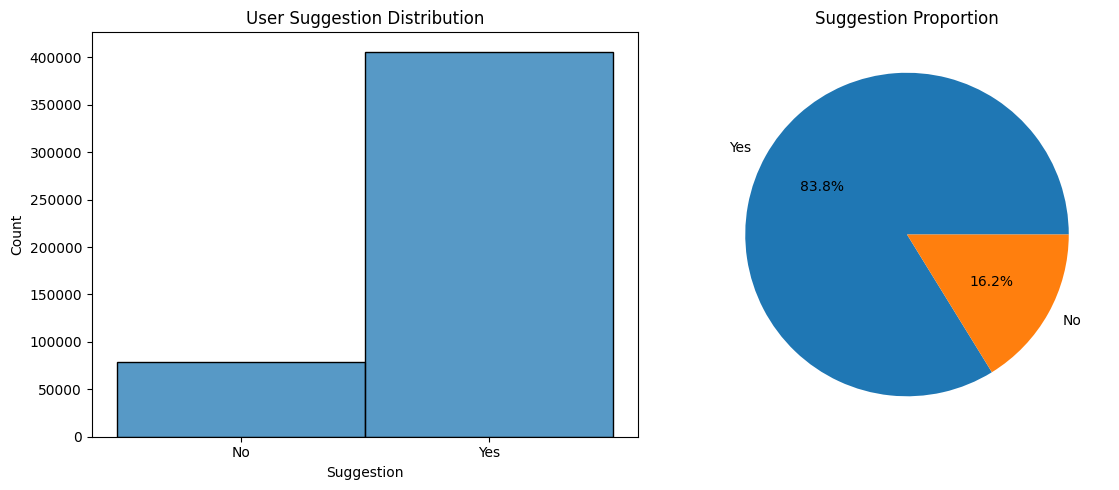

In [116]:
# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot 1: Recommended Product Distribution Histogram
sns.histplot(data=df, x='is_recommended', discrete=True, ax=axes[0])
axes[0].set_title('User Suggestion Distribution')
axes[0].set_xlabel('Suggestion')
axes[0].set_xticks([0, 1])
axes[0].set_xticklabels(['No', 'Yes'])

# Plot 2: Sentiment Pie Chart
df['is_recommended'].value_counts().plot(kind='pie', autopct='%1.1f%%', labels=['Yes', 'No'], ax=axes[1])
axes[1].set_title('Suggestion Proportion')
axes[1].set_ylabel('')

# Adjust layout to prevent overlapping
plt.tight_layout()

# Display the plots
plt.show()

The plot shows the distribution of user suggestions for a yes or no question. The left pie chart shows that 83.8% of users suggesting yes, while 16.2% suggesting no. 

The plot also shows a class imbalance, where one class has a significantly higher proportion of data points compared to the other. In this case, it's a binary classification problem with:

- **Majority Class**: This is the dominant class, represented by the larger pie slice (83.8%) who responded `Yes` in your example.
- **Minority Class**: This is the smaller class, represented by the smaller pie slice (16.2%) who responded `No`.

## Most Words Appear In Review

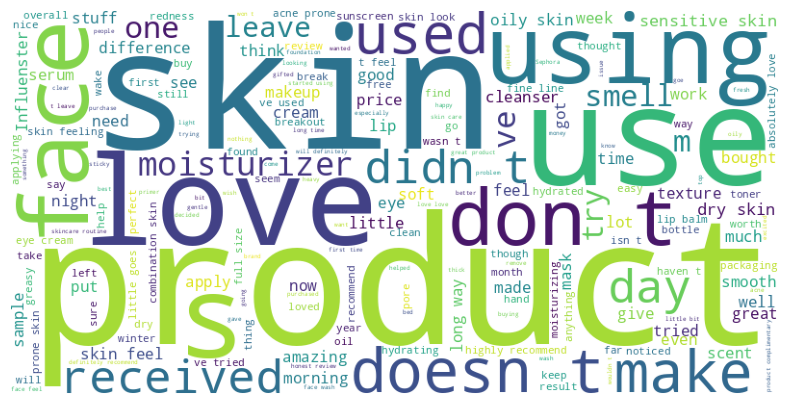

In [117]:
# Combines all tweet text into one string
all_review_text = ' '.join(df['review_text'].astype(str))

# Create WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_review_text)

# Displays WordCloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

The word cloud depicts words commonly found in skincare product reviews. Here are some of the most prominent words:

- **Moisturizer**: This suggests that the reviews are about a product that hydrates the skin.
- **Skin**: This is not surprising as the word cloud is about product reviews.
- **Love**: People seem to really like this product!
- **Dry**: This might be an indicator that the product is effective for dry skin.
- **Soft**: Another positive descriptor for the product’s effect on skin.
- **Cream**: This could be the type of product being reviewed.
- **Face**: This again reinforces that the reviews are about a facial skin care product.
- **Buy**: This indicates positive sentiment towards the product.
- **Price**: People are considering the price of the product in their reviews.
- **Breakout**: This suggests that some reviewers experienced irritation from the product.
- **Sensitive**: This indicates that the product might not be suitable for all skin types.

# 5. Feature Engineering

## Select Columns for Modeling

In [14]:
# Select only necessary columns
df_model = df[['review_title','review_text', 'is_recommended']]

# Drop missing values in 'review_title' and 'review_text' columns
df_model = df_model.dropna()

# Show the DataFrame
df_model

,review_title,review_text,is_recommended
0,Taught me how to double cleanse!,I use this with the Nudestix “Citrus Clean Bal...,1.0
1,Disappointed,I bought this lip mask after reading the revie...,0.0
2,New Favorite Routine,My review title says it all! I get so excited ...,1.0
3,Can't go wrong with any of them,I’ve always loved this formula for a long time...,1.0
4,A must have !!!,"If you have dry cracked lips, this is a must h...",1.0
...,...,...,...
602124,Best eye cream I have used,I have been using this product for over eight ...,1.0
602125,HOLY GRAIL- lash extension safe!!,I can’t say enough great things about this pro...,1.0
602126,Game changer!,I have been using this product for over 6 week...,1.0
602127,Triple Algae Eye Renewal Balm is a MUST HAVE,I love the Triple Algae Eye Renewal Balm! Once...,1.0


The columns `review_title`, `review_text`, and `is_recommended` are selected for Natural Language Processing (NLP) because review_title and review_text provide the textual data needed for NLP analysis, while is_recommended serves as the label for supervised learning tasks. The combination of these columns allows for the creation of models that can classify or predict recommendations based on the textual content of reviews.

In [15]:
# change is recommended data types
df_model['is_recommended'] = df_model['is_recommended'].astype(int)

Since the data type from `is_recommended` column is float then the data type is converted into integer.

In [16]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
Index: 331904 entries, 0 to 602129
Data columns (total 3 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   review_title    331904 non-null  object
 1   review_text     331904 non-null  object
 2   is_recommended  331904 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 10.1+ MB


Based on the output the data type of `is_recommended` have been successfully converted.

## Text Preprocessing

In [17]:
# Define Stopwords
stop_words = set(stopwords.words('english'))

# Define Stemming
stemmer = PorterStemmer()

The code snippet sets up the necessary components for text preprocessing in NLP by defining a set of stopwords and initializing a stemming tool. This preprocessing helps in cleaning and standardizing the text data for further analysis or modeling.

In [18]:
# Create a function for text preprocessing
def text_preprocessing(text):
  # Lower case
  text = text.lower()

  # Hashtags removal
  text = re.sub(r"#\w+", " ", text)

  # Newline removal (\n)
  text = re.sub(r"\\n", " ", text)

  # Whitespace removal
  text = text.strip()

  # Non-letter removal (such as emoticon, symbol (like μ, $, 兀), etc)
  text = re.sub(r"[^A-Za-z\s']", " ", text)

    # Tokenization
  tokens = word_tokenize(text)

  # Stopwords removal
  tokens = [word for word in tokens if word not in stop_words]

  # Stemming
  tokens = [stemmer.stem(word) for word in tokens]

  # Combining Tokens
  text = ' '.join(tokens)

  return text

The `text_preprocessing` function cleans and processes text to prepare it for analysis. It converts the text to lowercase, removes hashtags, newline characters, extra whitespace, and non-letter characters (like emoticons and symbols). It then tokenizes the text into individual words, removes common stopwords, and applies stemming to reduce words to their root forms. Finally, it combines the processed tokens back into a single string and returns the cleaned text. This preprocessing helps in standardizing the text for further natural language processing tasks.

In [20]:
# Applying Text Preprocessing to the Dataset
df_model['title_processed'] = df_model['review_title'].apply(lambda x: text_preprocessing(x))
df_model['text_processed'] = df_model['review_text'].apply(lambda x: text_preprocessing(x))

# concatenate the text
df_model['text'] = df_model['title_processed'] + ' ' + df_model['text_processed']
df_model

,review_title,review_text,is_recommended,title_processed,text_processed,text
0,Taught me how to double cleanse!,I use this with the Nudestix “Citrus Clean Bal...,1,taught doubl cleans,use nudestix citru clean balm make melt doubl ...,taught doubl cleans use nudestix citru clean b...
1,Disappointed,I bought this lip mask after reading the revie...,0,disappoint,bought lip mask read review hype unfortun meet...,disappoint bought lip mask read review hype un...
2,New Favorite Routine,My review title says it all! I get so excited ...,1,new favorit routin,review titl say get excit get bed appli lip ma...,new favorit routin review titl say get excit g...
3,Can't go wrong with any of them,I’ve always loved this formula for a long time...,1,ca n't go wrong,alway love formula long time honestli even use...,ca n't go wrong alway love formula long time h...
4,A must have !!!,"If you have dry cracked lips, this is a must h...",1,must,dri crack lip must week use learn alway bedsid...,must dri crack lip must week use learn alway b...
...,...,...,...,...,...,...
602124,Best eye cream I have used,I have been using this product for over eight ...,1,best eye cream use,use product eight week excit result thu far co...,best eye cream use use product eight week exci...
602125,HOLY GRAIL- lash extension safe!!,I can’t say enough great things about this pro...,1,holi grail lash extens safe,say enough great thing product night shift nur...,holi grail lash extens safe say enough great t...
602126,Game changer!,I have been using this product for over 6 week...,1,game changer,use product week seen signific differ dark cir...,game changer use product week seen signific di...
602127,Triple Algae Eye Renewal Balm is a MUST HAVE,I love the Triple Algae Eye Renewal Balm! Once...,1,tripl alga eye renew balm must,love tripl alga eye renew balm put actual feel...,tripl alga eye renew balm must love tripl alga...


This code snippet applies a text preprocessing function to the `review_title` and `review_text` columns in a dataset (`df_model`). 

It processes each title and review text to clean and standardize the content. The processed titles and texts are stored in new columns, `title_processed` and `text_processed`, respectively. These preprocessed columns are then concatenated to form a single text column, `text`, which combines the cleaned title and review text for each entry. This combined text can be used for further natural language processing tasks or modeling.

## Split Train, Validation, and Test

In [21]:
# Data Splitting
X_train_val, X_test, y_train_val, y_test = train_test_split(df_model['text'],
                                                    df_model['is_recommended'],
                                                    test_size=0.15,
                                                    random_state=46,
                                                    stratify=df_model['is_recommended'])

X_train, X_val, y_train, y_val = train_test_split(X_train_val,
                                                  y_train_val,
                                                  test_size=0.10,
                                                  random_state=46,
                                                  stratify=y_train_val)

print('Train Size : ', X_train.shape)
print('Val Size   : ', X_val.shape)
print('Test Size  : ', X_test.shape)

Train Size :  (253906,)
Val Size   :  (28212,)
Test Size  :  (49786,)


The data is split into training, validation, and test sets to prepare for model evaluation. Initially, 85% of the data is allocated to the training/validation set, and 15% to the test set, ensuring the class distribution remains the same. Then, the training/validation set is further split, with 10% set aside for validation. The final sizes of the datasets are 253,906 samples for training, 28,212 for validation, and 49,786 for testing. This setup helps ensure that the model can be properly trained, tuned, and evaluated.

## Finding Number of Vocab and Max Token Lenght

In [22]:
# Vectorize Text
Vectorize = CountVectorizer()
X_train_vec = Vectorize.fit_transform(X_train)
X_val_vec = Vectorize.transform(X_val)
X_test_vec = Vectorize.transform(X_test)

# Show vectorized X_train
X_train_vec

<253906x30208 sparse matrix of type '<class 'numpy.int64'>'
	with 7145561 stored elements in Compressed Sparse Row format>

In [23]:
# Finding the Number of Vocabs and Max Token Length in One Document
total_vocab = len(Vectorize.vocabulary_.keys())
max_sen_len = max([len(i.split(" ")) for i in X_train])

print('Total Vocab : ', total_vocab)
print('Maximum Sentence Length : ', max_sen_len, 'tokens')

Total Vocab :  30208
Maximum Sentence Length :  233 tokens


The `CountVectorizer` from `scikit-learn` is used to transform the text data into a matrix of token counts.

The total number of unique words (vocabulary) in the training set is calculated from the vectorizer's vocabulary giving output 30208 of total vocab.

The maximum number of tokens (words) in any single document (review) in the training set is determined by splitting each document into words and finding the longest one giving output of 233 tokens.

## Text Vectorization

In [24]:
# Text Vectorization
text_vectorization = TextVectorization(max_tokens=total_vocab,
                                       standardize="lower_and_strip_punctuation",
                                       split="whitespace",
                                       ngrams=None,
                                       output_mode="int",
                                       output_sequence_length=max_sen_len,
                                       input_shape=(1,)) # Only use in Sequential API

text_vectorization.adapt(X_train)

The code sets up a text vectorization process using TensorFlow's `TextVectorization` layer. It configures the layer to convert text to lowercase, remove punctuation, split text by whitespace, and limit the vocabulary to the unique words found in the training data. The text is then tokenized into integers, with sequences padded or truncated to the length of the longest sentence. Finally, the layer is adapted to the training data to learn its vocabulary, preparing the text for input into a neural network.

In [25]:
text_vectorization.get_vocabulary()[:20]

['',
 '[UNK]',
 'skin',
 'use',
 'product',
 'love',
 'feel',
 'like',
 'moistur',
 'face',
 'dri',
 'great',
 'realli',
 'tri',
 'look',
 'hydrat',
 'smell',
 'cream',
 'make',
 'day']

In [26]:
## Document example
print('Document example')
print(df_model.text_processed[0])
print('')

## Result of Text Vectorization
print('Result of Text Vectorization')
print(text_vectorization([df_model.text_processed[0]]))
print('Vector size : ', text_vectorization([df_model.text_processed[0]]).shape)

Document example
use nudestix citru clean balm make melt doubl cleans complet chang skin better make melt oil base remov makeup super easili follow water base cleanser also use wear make leav skin gentli cleans without strip skin recommend combin make melt perfect

Result of Text Vectorization
tf.Tensor(
[[    3 10297   874    70    97    18   301   388   107   224   141     2
     79    18   301    64   293    95    23    62   247   353   161   293
     49    31     3   124    18    36     2   601   107    82   326     2
     27   143    18   301    96     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0   

## Embedding

In [27]:
# Embedding
embedding = Embedding(input_dim=total_vocab,
                      output_dim=128,
                      embeddings_initializer="uniform")

The code creates an embedding layer for a neural network using TensorFlow. This layer converts input text into dense 128-dimensional vectors. The `input_dim` parameter is set to the total vocabulary size, ensuring that each unique word has a corresponding vector. 

The embeddings are initialized uniformly, meaning the initial values of the vectors are uniformly distributed. This embedding layer helps the model learn meaningful representations of words during training.

In [28]:
## Result of  Embedding
print('Result of  Embedding')
print(embedding(text_vectorization([df_model.text_processed[0]])))
print('Vector size : ', embedding(text_vectorization([df_model.text_processed[0]])).shape)

Result of  Embedding
tf.Tensor(
[[[-0.00444943 -0.0163907   0.04334496 ... -0.00335355 -0.00856119
    0.01663827]
  [ 0.02144635  0.014261   -0.03870738 ... -0.00983381  0.0090365
   -0.0428138 ]
  [ 0.01863701  0.01905693 -0.03709074 ...  0.03207299 -0.00023735
   -0.02067542]
  ...
  [-0.04612271  0.00327395  0.02283784 ...  0.0188702   0.01532943
    0.02392827]
  [-0.04612271  0.00327395  0.02283784 ...  0.0188702   0.01532943
    0.02392827]
  [-0.04612271  0.00327395  0.02283784 ...  0.0188702   0.01532943
    0.02392827]]], shape=(1, 233, 128), dtype=float32)
Vector size :  (1, 233, 128)


# 6. ANN Training

## Model Definition

In [29]:
## Clear Session
seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

# Define the architecture
model_lstm_1 = Sequential()
model_lstm_1.add(text_vectorization)
model_lstm_1.add(embedding)
model_lstm_1.add(LSTM(32, return_sequences=True))  # Avoiding custom initializers for compatibility
model_lstm_1.add(LSTM(16, return_sequences=True))  # Avoiding custom initializers for compatibility
model_lstm_1.add(LSTM(8))
model_lstm_1.add(Dense(1, activation='sigmoid'))

# Ensure loss function is correct
model_lstm_1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model_lstm_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 233)               0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 233, 128)          3866624   
                                                                 
 lstm (LSTM)                 (None, 233, 32)           20608     
                                                                 
 lstm_1 (LSTM)               (None, 233, 16)           3136      
                                                                 
 lstm_2 (LSTM)               (None, 8)                 800       
                                                                 
 dense (Dense)               (None, 1)                 9         
                                                        

The code defines a sequential neural network model (`model_lstm_1`) using TensorFlow and Keras. First, it clears any existing session and sets a random seed for reproducibility. The model architecture consists of:
- A text vectorization layer (`text_vectorization`) that preprocesses and tokenizes input text data.
- An embedding layer (`embedding`) that converts tokens into dense vectors of 128 dimensions.
- Three LSTM (Long Short-Term Memory) layers configured sequentially: the first two layers (`LSTM(32)` and `LSTM(16)`) return sequences to the subsequent layers, while the last LSTM layer (`LSTM(8)`) does not return sequences.
- A dense layer (`Dense(1, activation='sigmoid')`) with a sigmoid activation function, which outputs a binary classification prediction.

The model is compiled with the binary cross-entropy loss function and the Adam optimizer, evaluating accuracy as a metric. 

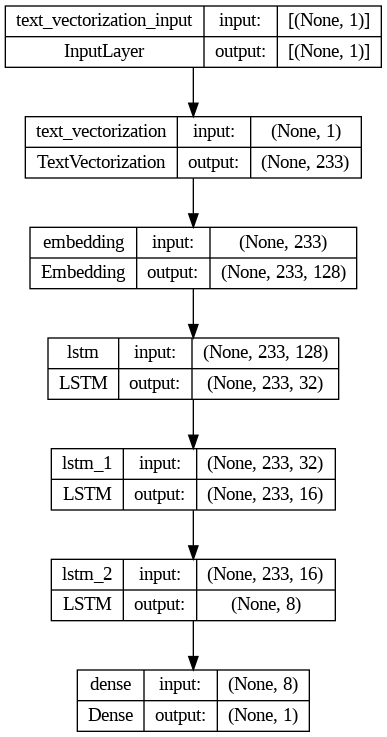

In [30]:
# plot the model
plot_model(model_lstm_1, show_shapes=True, show_layer_names=True)

## Model Training

In [31]:
# Assign callback to speed up computing and reduce learning rate
callbacks= [
    EarlyStopping(
        monitor='val_accuracy',
        patience=5,
        verbose=0,
        restore_best_weights=True
        ),
    ReduceLROnPlateau(
        monitor='val_accuracy',
        factor=0.01,
        patience=2
        )
]

In [32]:
# model training
model_lstm_1_hist = model_lstm_1.fit(X_train,
                                     y_train,
                                     epochs=20,
                                     batch_size=64,
                                     validation_data=(X_val, y_val),
                                     callbacks=callbacks)

Epoch 1/20
3968/3968 [==============================] - 132s 32ms/step - loss: 0.4533 - accuracy: 0.8317 - val_loss: 0.4527 - val_accuracy: 0.8320 - lr: 0.0010
Epoch 2/20
3968/3968 [==============================] - 100s 25ms/step - loss: 0.4527 - accuracy: 0.8320 - val_loss: 0.4529 - val_accuracy: 0.8320 - lr: 0.0010
Epoch 3/20
3968/3968 [==============================] - 98s 25ms/step - loss: 0.4528 - accuracy: 0.8320 - val_loss: 0.4527 - val_accuracy: 0.8320 - lr: 0.0010
Epoch 4/20
3968/3968 [==============================] - 99s 25ms/step - loss: 0.4527 - accuracy: 0.8320 - val_loss: 0.4527 - val_accuracy: 0.8320 - lr: 1.0000e-05
Epoch 5/20
3968/3968 [==============================] - 98s 25ms/step - loss: 0.4527 - accuracy: 0.8320 - val_loss: 0.4527 - val_accuracy: 0.8320 - lr: 1.0000e-05
Epoch 6/20
3968/3968 [==============================] - 97s 25ms/step - loss: 0.4527 - accuracy: 0.8320 - val_loss: 0.4527 - val_accuracy: 0.8320 - lr: 1.0000e-07


The code snippet sets up and trains a deep learning model (`model_lstm_1`) for text classification. Two callbacks are assigned to optimize training:
- **EarlyStopping**: Monitors validation accuracy and stops training if no improvement is seen after 5 epochs (`patience=5`). It restores the model weights to the best observed during training (`restore_best_weights=True`).
- **ReduceLROnPlateau**: Adjusts the learning rate if validation accuracy does not improve for 2 consecutive epochs (`patience=2`), decreasing it by a factor of 0.01 (`factor=0.01`).

The model is trained using the training data (`X_train` and `y_train`) for 20 epochs with a batch size of 64. Validation data (`X_val` and `y_val`) is used to evaluate the model's performance after each epoch. These callbacks help in speeding up computation by stopping early when further training is deemed unnecessary and by optimizing the learning rate dynamically based on validation performance.

## Model Evaluation

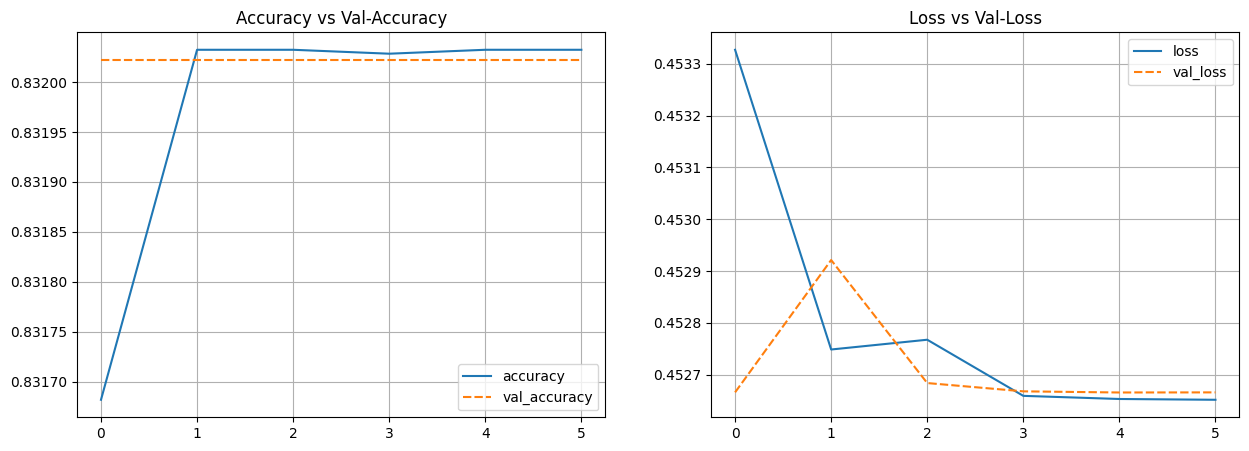

In [33]:
# Plot Training Results
model_lstm_1_hist_df = pd.DataFrame(model_lstm_1_hist.history)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=model_lstm_1_hist_df[['accuracy', 'val_accuracy']])
plt.grid()
plt.title('Accuracy vs Val-Accuracy')

plt.subplot(1, 2, 2)
sns.lineplot(data=model_lstm_1_hist_df[['loss', 'val_loss']])
plt.grid()
plt.title('Loss vs Val-Loss')

plt.show()

In [91]:
# Predict and evaluate model 1
y_pred_proba_1 = model_lstm_1.predict(X_test)
y_pred_biner_1 = tf.where(y_pred_proba_1 >= 0.5, 1, 0)
report_1 = classification_report(y_test, y_pred_biner_1)

test_loss_1, test_accuracy_1 = model_lstm_1.evaluate(X_test, y_test)

print(f"Test Loss: {test_loss_1}")
print(f"Test Accuracy: {test_accuracy_1}")
print(report_1)

1556/1556 [==============================] - 17s 11ms/step - loss: 0.4527 - accuracy: 0.8320
Test Loss: 0.452666699886322
Test Accuracy: 0.8320210576057434
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      8363
           1       0.83      1.00      0.91     41423

    accuracy                           0.83     49786
   macro avg       0.42      0.50      0.45     49786
weighted avg       0.69      0.83      0.76     49786



Based on the provided metric scores, the model achieved an overall test accuracy of approximately 83.2%. <br>
The test loss, which measures the model's error during training, is 0.453. 

- **Precision** measures the proportion of correctly predicted instances among all instances predicted as a particular class. For class 1 (recommended), the precision is 0.83, indicating that 83% of the predicted recommended reviews are correct.
- **Recall** indicates the proportion of actual instances of a class that were correctly predicted by the model. For class 1, the recall is 1.0, meaning the model correctly identified all actual recommended reviews.
- **F1-score** is the harmonic mean of precision and recall, providing a single metric that balances both measures. The F1-score for class 1 is 0.91, reflecting good overall performance in predicting recommended reviews.

However, for class 0 (not recommended), the model's precision, recall, and F1-score are 0.0, indicating that it failed to correctly predict any instances of non-recommended reviews. The macro and weighted averages provide an overall assessment across both classes, highlighting areas where the model may need improvement, particularly in detecting non-recommended reviews.








# 7. ANN Improvement

## Model Definition

In [81]:
# Clear Session
seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

# Define the architecture
model_lstm_2 = Sequential()
model_lstm_2.add(text_vectorization)
model_lstm_2.add(embedding)
model_lstm_2.add(Bidirectional(LSTM(64, return_sequences=True, kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))
model_lstm_2.add(Dropout(0.15))
model_lstm_2.add(Bidirectional(LSTM(32, kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))
model_lstm_2.add(Dropout(0.15))
model_lstm_2.add(Dense(1, activation='sigmoid'))

# Compile the model
model_lstm_2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model_lstm_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 233)               0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 233, 128)          3866624   
                                                                 
 bidirectional (Bidirection  (None, 233, 128)          98816     
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 233, 128)          0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 64)                41216     
 onal)                                                           
                                                        

The second model (`model_lstm_2`) is designed to improve performance and robustness for text classification using deep learning. Certain method are added to ensure model performance and model robustness:
- **Bidirectional LSTM**: By processing sequences in both directions, the model can capture context dependencies more effectively, especially useful in understanding the nuanced sentiment and context in reviews.
- **Dropout**: Regularizes the network by preventing overfitting. During training, it randomly drops a fraction of connections between layers, forcing the model to learn more robust features and reducing reliance on specific neurons.
- **Kernel Initializer**: The Glorot uniform initializer (`tf.keras.initializers.GlorotUniform(seed)`) sets initial weights of the Bidirectional LSTM layers. This initialization method helps in stabilizing the learning process by ensuring weights are initialized neither too small nor too large, which can speed up convergence and improve overall performance.

The second model (`model_lstm_2`) integrates Bidirectional LSTM layers, dropout regularization, and careful weight initialization to enhance its ability to classify text data accurately. These methods collectively aim to mitigate overfitting, capture richer context from sequential data, and establish stable learning dynamics, thereby improving the model's performance in predicting whether a review is recommended or not based on its textual content.

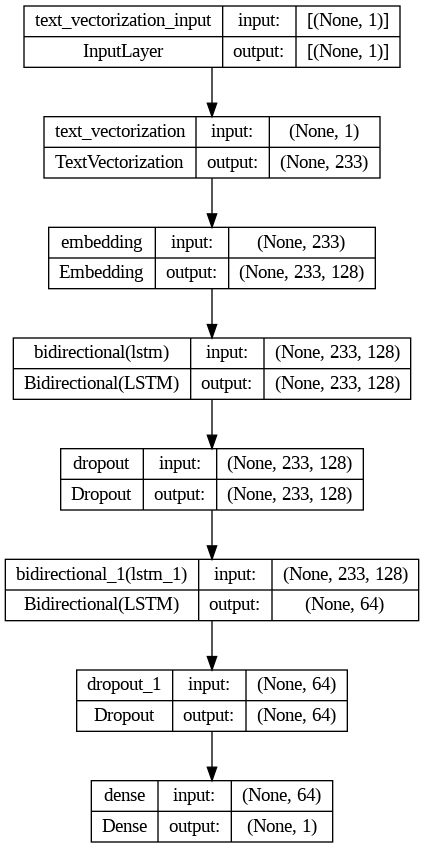

In [82]:
# plot the model
plot_model(model_lstm_2, show_shapes=True, show_layer_names=True)

## Model Training

In [83]:
# Assign callbacks to speed up computing and reduce learning rate
callbacks = [
    EarlyStopping(
        monitor='val_accuracy',
        patience=5,
        verbose=1,
        restore_best_weights=True
    ),
    ReduceLROnPlateau(
        monitor='val_accuracy',
        factor=0.1,
        patience=2,
        verbose=1
    )
]

In [84]:
# Model training
model_lstm_2_hist = model_lstm_2.fit(X_train,
                                     y_train,
                                     epochs=25,
                                     batch_size=64,
                                     validation_data=(X_val, y_val),
                                     callbacks=callbacks)

Epoch 1/25
3968/3968 [==============================] - 161s 39ms/step - loss: 0.1040 - accuracy: 0.9604 - val_loss: 0.1483 - val_accuracy: 0.9479 - lr: 0.0010
Epoch 2/25
3968/3968 [==============================] - 129s 32ms/step - loss: 0.0646 - accuracy: 0.9760 - val_loss: 0.1617 - val_accuracy: 0.9491 - lr: 0.0010
Epoch 3/25
3968/3968 [==============================] - 127s 32ms/step - loss: 0.0503 - accuracy: 0.9815 - val_loss: 0.1886 - val_accuracy: 0.9480 - lr: 0.0010
Epoch 4/25
3968/3968 [==============================] - ETA: 0s - loss: 0.0427 - accuracy: 0.9848
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
3968/3968 [==============================] - 128s 32ms/step - loss: 0.0427 - accuracy: 0.9848 - val_loss: 0.1902 - val_accuracy: 0.9464 - lr: 0.0010
Epoch 5/25
3968/3968 [==============================] - 126s 32ms/step - loss: 0.0257 - accuracy: 0.9913 - val_loss: 0.2365 - val_accuracy: 0.9473 - lr: 1.0000e-04
Epoch 6/25
3968/3968 [==========

The model is trained on the training data (`X_train` and `y_train`) for 25 epochs with a batch size of 64. Validation data (X_val and y_val) is used to evaluate the model's performance after each epoch. 

## Model Evaluation

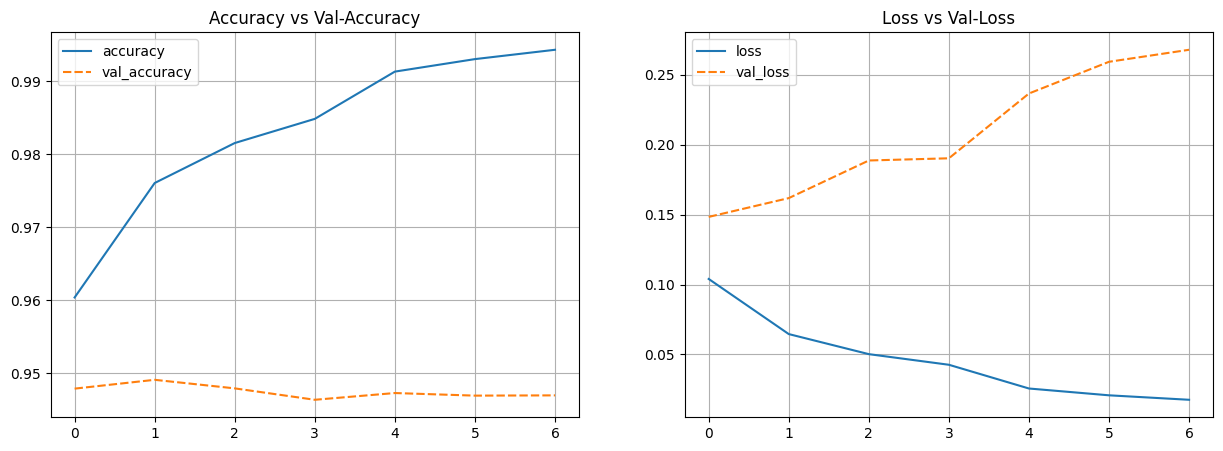

In [85]:
# Plot Training Results
model_lstm_2_hist_df = pd.DataFrame(model_lstm_2_hist.history)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=model_lstm_2_hist_df[['accuracy', 'val_accuracy']])
plt.grid()
plt.title('Accuracy vs Val-Accuracy')

plt.subplot(1, 2, 2)
sns.lineplot(data=model_lstm_2_hist_df[['loss', 'val_loss']])
plt.grid()
plt.title('Loss vs Val-Loss')

plt.show()

In [97]:
# Predict and evaluate model 2
y_pred_proba_2 = model_lstm_2.predict(X_test)
y_pred_biner_2 = tf.where(y_pred_proba_2 >= 0.5, 1, 0)

test_loss_2, test_accuracy_2 = model_lstm_2.evaluate(X_test, y_test)

print('')
print(f"Test Loss: {test_loss_2}")
print(f"Test Accuracy: {test_accuracy_2}")
print('')
print(classification_report(y_test, y_pred_biner_2))

1556/1556 [==============================] - 21s 13ms/step - loss: 0.1662 - accuracy: 0.9485

Test Loss: 0.16622905433177948
Test Accuracy: 0.9485397338867188

              precision    recall  f1-score   support

           0       0.86      0.83      0.84      8363
           1       0.97      0.97      0.97     41423

    accuracy                           0.95     49786
   macro avg       0.91      0.90      0.91     49786
weighted avg       0.95      0.95      0.95     49786



The second model's metrics indicate a significant improvement over the first model in terms of accuracy and F1-score, especially for the minority class (0 or non-recommended).

- **Accuracy**: The second model achieved an accuracy of approximately 94.85% on the test set, which is considerably higher than the first model’s 83.20%.
- **Precision and Recall**:
    - For the non-recommended class (0), precision was 86% and recall was 83%.
    - For the recommended class (1), precision was 97% and recall was 97%.
- **F1-score**: The weighted average F1-score across both classes was 95%, indicating a robust performance in classifying reviews into recommended and non-recommended categories.

The second model demonstrates strong performance with high accuracy and balanced precision and recall across both classes. It achieves an F1-score of 0.84 for class 0 and 0.97 for class 1, indicating robustness in classifying both minority and majority classes. The high accuracy of 94.85% on the test set suggests that the model generalizes well and performs effectively across different instances. 

# 8. Model Saving

In [104]:
model_lstm_2.save('model.keras')

## 9. Model Inference

The model inference will be done in another notebook named `P2G7_devi_nirfana_inference.ipynb`

# 10. Conclusion

In [98]:
# Extracting key metrics from the classification reports
report_1_dict = classification_report(y_test, y_pred_biner_1, output_dict=True)
report_2_dict = classification_report(y_test, y_pred_biner_2, output_dict=True)

# Create a DataFrame to hold the results
results = {
    'Model': ['LSTM Model 1', 'LSTM Model 2'],
    'Test Loss': [test_loss_1, test_loss_2],
    'Test Accuracy': [test_accuracy_1, test_accuracy_2],
    'Precision': [report_1_dict['weighted avg']['precision'], report_2_dict['weighted avg']['precision']],
    'Recall': [report_1_dict['weighted avg']['recall'], report_2_dict['weighted avg']['recall']],
    'F1-Score': [report_1_dict['weighted avg']['f1-score'], report_2_dict['weighted avg']['f1-score']]
    }

df_results = pd.DataFrame(results)
print("\nComparison Table:")
df_results


Comparison Table:


,Model,Test Loss,Test Accuracy,Precision,Recall,F1-Score
0,LSTM Model 1,0.452667,0.832021,0.692259,0.832021,0.755733
1,LSTM Model 2,0.166229,0.948540,0.947949,0.948540,0.948196


Based on the comparison of LSTM Model 1 and LSTM Model 2 using the provided metrics:

**Test Metrics**:
- Test Loss: LSTM Model 1 has a higher test loss of 0.4527 compared to LSTM Model 2, which has a lower test loss of 0.1662. Lower loss values indicate better model performance in terms of minimizing errors during predictions.
- Test Accuracy: LSTM Model 2 achieves a higher test accuracy of 94.85%, while LSTM Model 1 has a lower accuracy of 83.20%.

**Precision, Recall, and F1-Score**:
- Precision: LSTM Model 2 shows higher precision (94.79%) compared to LSTM Model 1 (69.23%). Higher precision indicates that when the model predicts a class, it is more likely to be correct.
- Recall: Both models have the same recall score of 83.20%. Recall measures the ability of the model to identify all relevant instances of a class.
- F1-Score: LSTM Model 2 achieves a higher F1-score (94.82%) compared to LSTM Model 1 (75.57%). F1-score balances precision and recall, providing a single metric to evaluate the model's overall performance.

### **Overall Analysis**
LSTM Model 2 outperforms LSTM Model 1 in all evaluated metrics, including accuracy, precision, recall, and F1-score. It demonstrates better predictive capability and generalization on the test dataset.

Considering that the dataset is imbalanced (as indicated by the significant difference in support between class 0 and class 1), the models should be evaluated with additional metrics like ROC-AUC or PR-AUC to assess performance across different thresholds and better handle class imbalance.

### **Recommendations for Further Improvements**
- **Feature Engineering**: Experimenting with different feature extraction techniques to capture more context from the reviews. Apply techniques like stemming, lemmatization, and spell checking to reduce vocabulary size and improve model generalization.
- **Learning Rate Scheduling**: Implement learning rate schedules (e.g., decay schedules, cyclical learning rates) to optimize convergence and improve model training efficiency.
- **Class Weight Adjustment**: Adjust class weights during training to penalize misclassifications of minority classes more heavily, addressing class imbalance issues.
- **Pre-trained Embeddings**: Utilize pre-trained word embeddings (e.g., Word2Vec, GloVe, BERT embeddings) to initialize LSTM layers, leveraging transfer learning to improve model performance on specific tasks.
- **Advanced Models**: Exploring more sophisticated NLP models like BERT or GPT for better performance.